In [6]:
import sys, os
sys.path.insert(0, os.path.dirname(os.path.abspath('__file__')))

import numpy as np

import config
from config import THICKNESS, RAYLEIGH_ALPHA, RAYLEIGH_BETA


from beam_element import element_stiffness, element_mass, compute_section_properties
from assembly import generate_mesh, assemble_global_matrices, apply_boundary_conditions
from damping import build_rayleigh_damping, rayleigh_from_damping_ratios
from materials import get_material, list_materials, add_material


All matrices rebuilt successfully
  K_free shape : (200, 200)
  M_free shape : (200, 200)
  C_free shape : (200, 200)
  F_global shape: (200, 2000)
Solver Output:
  accel_history shape : (200, 2000)
  Max acceleration    : 285183.1167 in/s²
  Any NaN values      : False
  Any Inf values      : False



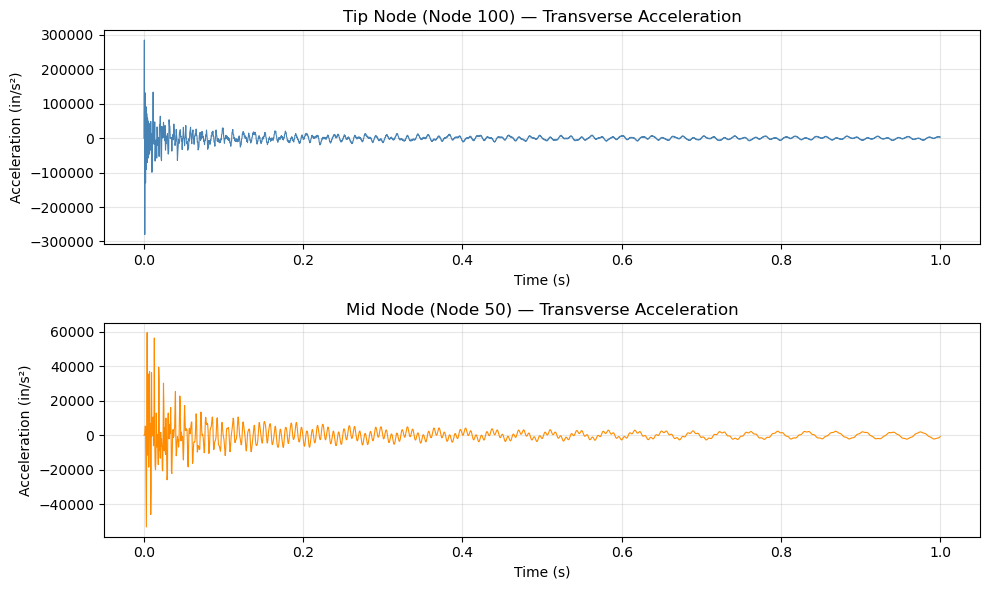

In [7]:
# Cell 1 — rebuild all matrices from scratch
import numpy as np
import config
from materials import get_material
from assembly import assemble_global_matrices, apply_boundary_conditions
from damping import build_rayleigh_damping
from excitation import build_force_vector
from config import THICKNESS

# Parameters
mat  = get_material('steel')
b    = 0.5
t    = THICKNESS
L    = 60.0
F0   = 100.0

# Assemble
K, M                      = assemble_global_matrices(mat['E'], mat['rho'], b, t, L)
K_free, M_free, free_dofs = apply_boundary_conditions(K, M)
C_free                    = build_rayleigh_damping(M_free, K_free)
F_global, force_time, time_vector = build_force_vector(F0, free_dofs)

print("All matrices rebuilt successfully")
print("  K_free shape :", K_free.shape)
print("  M_free shape :", M_free.shape)
print("  C_free shape :", C_free.shape)
print("  F_global shape:", F_global.shape)
import numpy as np
import matplotlib.pyplot as plt
from time_integrator import newmark_beta_solver
from config import DT, N_STEPS

# Run solver with existing matrices
accel_history = newmark_beta_solver(M_free, C_free, K_free, F_global)

print("Solver Output:")
print("  accel_history shape :", accel_history.shape)
print("  Max acceleration    :", round(np.max(np.abs(accel_history)), 4), "in/s²")
print("  Any NaN values      :", np.any(np.isnan(accel_history)))
print("  Any Inf values      :", np.any(np.isinf(accel_history)))
print()

# Time vector
time_vector = np.linspace(0, DT * (N_STEPS - 1), N_STEPS)

# Plot acceleration at tip node (free end = DOF 198)
# Plot acceleration at mid node (mid beam = DOF 98)
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].plot(time_vector, accel_history[198, :], color='steelblue', linewidth=0.8)
axes[0].set_title("Tip Node (Node 100) — Transverse Acceleration")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Acceleration (in/s²)")
axes[0].grid(True, alpha=0.3)

axes[1].plot(time_vector, accel_history[98, :], color='darkorange', linewidth=0.8)
axes[1].set_title("Mid Node (Node 50) — Transverse Acceleration")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Acceleration (in/s²)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Verification cell for sensors.py
import numpy as np
from sensors import extract_node_accelerations, get_node_labels, serialize_node_accel
from config import N_NODES, N_STEPS

# Extract node accelerations
node_accels = extract_node_accelerations(accel_history, free_dofs)

print("Sensor Extraction:")
print("  node_accels shape     :", node_accels.shape)
print("  Node 0  (fixed end)   :", round(np.max(np.abs(node_accels[0, :])), 6),
      "in/s²  ← should be 0.0")
print("  Node 50 (mid) max     :", round(np.max(np.abs(node_accels[50, :])), 2),
      "in/s²")
print("  Node 100 (tip) max    :", round(np.max(np.abs(node_accels[100, :])), 2),
      "in/s²")
print()

# Node labels
labels = get_node_labels()
print("Node Labels:")
print("  First label :", labels[0])
print("  Last label  :", labels[-1])
print("  Total labels:", len(labels))
print()

# Serialization test
serialized = serialize_node_accel(node_accels[100, :])
values     = serialized.split(';')
print("Serialization Test (Tip Node):")
print("  Total values in string :", len(values))
print("  First value            :", values[0])
print("  Last value             :", values[-1])
print("  Preview                :", ';'.join(values[:5]), "...")

Sensor Extraction:
  node_accels shape     : (101, 2000)
  Node 0  (fixed end)   : 0.0 in/s²  ← should be 0.0
  Node 50 (mid) max     : 59665.79 in/s²
  Node 100 (tip) max    : 285183.12 in/s²

Node Labels:
  First label : node_001_accel
  Last label  : node_101_accel
  Total labels: 101

Serialization Test (Tip Node):
  Total values in string : 2000
  First value            : 0.000000
  Last value             : 3457.468448
  Preview                : 0.000000;285183.116677;-279699.735398;131883.485151;-129648.579034 ...


In [9]:
# Verification cell for sampling.py
from sampling import generate_parameter_sets

# Generate 500 parameter sets
param_sets = generate_parameter_sets(mode=1)

print()
print("Parameter Sets Summary:")
print("  Total sets generated :", len(param_sets))
print()
print("First parameter set:")
for k, v in param_sets[0].items():
    print(f"  {k:<20} : {v}")
print()
print("Last parameter set:")
for k, v in param_sets[-1].items():
    print(f"  {k:<20} : {v}")
print()

# Check material distribution
materials = [p['material'] for p in param_sets]
steel_count    = materials.count('steel')
aluminum_count = materials.count('aluminum')
print("Material distribution:")
print(f"  Steel    : {steel_count}")
print(f"  Aluminum : {aluminum_count}")
print()

# Check length distribution
lengths = [p['length_in'] for p in param_sets]
print("Length distribution:")
for L in sorted(set(lengths)):
    print(f"  L={L:5.0f} in : {lengths.count(L)} simulations")


Total possible combinations : 720
Simulations requested       : 500

Parameter Sets Summary:
  Total sets generated : 500

First parameter set:
  sim_id               : 0
  material             : aluminum
  E_psi                : 10000000.0
  rho_lbm_in3          : 0.0998
  rho_consistent       : 0.00025849029236857916
  length_in            : 140
  width_in             : 0.5
  thickness_in         : 0.5
  impact_F0_lbf        : 45
  impact_tau_s         : 0.001
  rayleigh_alpha       : 0.01
  rayleigh_beta        : 1e-05
  dt_s                 : 0.0005002501250625312
  T_s                  : 1.0
  n_steps              : 2000
  n_elements           : 100
  n_nodes              : 101

Last parameter set:
  sim_id               : 499
  material             : steel
  E_psi                : 29000000.0
  rho_lbm_in3          : 0.283
  rho_consistent       : 0.0007329935144319428
  length_in            : 100
  width_in             : 0.9
  thickness_in         : 0.5
  impact_F0_lbf        : 9

In [10]:
# Verification cell for batch_runner.py
from batch_runner import run_batch
from sampling import generate_parameter_sets
import time

# Generate parameter sets
param_sets = generate_parameter_sets(mode=1)

# First test with just 3 simulations to verify
print("Running test batch of 3 simulations...")
test_params = param_sets[:3]

start = time.time()
results, n_success, n_failed = run_batch(test_params, n_jobs=1)
elapsed = time.time() - start

print()
print("Test Batch Results:")
print(f"  Time taken     : {round(elapsed, 2)} s")
print(f"  Succeeded      : {n_success}")
print(f"  Failed         : {n_failed}")
print()

# Check first result
r = results[0]
print("First result:")
print(f"  sim_id         : {r['params']['sim_id']}")
print(f"  status         : {r['status']}")
print(f"  material       : {r['params']['material']}")
print(f"  length         : {r['params']['length_in']} in")
print(f"  node_accels shape : {r['node_accels'].shape}")
print(f"  tip max accel  : {round(r['node_accels'][100].max(), 2)} in/s²")

Total possible combinations : 720
Simulations requested       : 500
Running test batch of 3 simulations...
Starting batch of 3 simulations...
Using n_jobs = 1 (−1 means all CPU cores)



Simulations: 100%|██████████| 3/3 [00:00<00:00,  3.19sim/s]


Batch complete.
  Succeeded : 3
  Failed    : 0

Test Batch Results:
  Time taken     : 0.94 s
  Succeeded      : 3
  Failed         : 0

First result:
  sim_id         : 0
  status         : success
  material       : aluminum
  length         : 140 in
  node_accels shape : (101, 2000)
  tip max accel  : 365928.74 in/s²


In [ ]:
# Verification cell for exporter.py
from exporter import export_results_to_csv, export_time_vector
import pandas as pd

# Use the 3 test results from batch_runner verification
df = export_results_to_csv(results, output_path='test_export.csv')

print()
print("DataFrame Info:")
print(f"  Shape          : {df.shape}")
print(f"  First columns  : {list(df.columns[:5])}")
print(f"  Last columns   : {list(df.columns[-3:])}")
print()
print("First row metadata:")
print(df[['sim_id','material','length_in',
          'width_in','impact_F0_lbf']].iloc[0])
print()
print("Node 100 (tip) preview:")
print(" ", df['node_100_accel'].iloc[0][:60], "...")
print()

# Export time vector
df_time = export_time_vector()

STEP 1 — Generating 500 parameter sets
Total possible combinations : 720
Simulations requested       : 500
  Parameter sets ready : 500

STEP 2 — Running 500 simulations in parallel
Starting batch of 500 simulations...
Using n_jobs = -1 (−1 means all CPU cores)



Simulations: 100%|██████████| 500/500 [00:30<00:00, 16.16sim/s]



Batch complete.
  Succeeded : 500
  Failed    : 0

  Total time     : 32.82 s
  Time per sim   : 0.066 s

STEP 3 — Exporting results to CSV
Exporting 500 simulations to CSV...
Encoding : A

CSV saved to   : beam_vibration_dataset.csv
Rows exported  : 500
Total columns  : 118
Metadata cols  : 17
Node cols      : 101
File size      : 1230.02 MB
Time vector saved to : time_vector.csv
  Steps  : 2000
  t_start: 0.0 s
  t_end  : 1.0 s
  dt     : 0.0005 s

STEP 4 — Summary
  Simulations total    : 500
  Succeeded            : 500
  Failed               : 0
  CSV shape            : (500, 118)
  Total time           : 32.82 s

Materials in dataset:
material
steel       257
aluminum    243

Length distribution:
length_in
20     61
40     62
60     59
80     67
100    68
120    70
140    56
160    57

Example row (first sim metadata):
sim_id                     0
material            aluminum
E_psi             10000000.0
length_in                140
width_in                 0.5
thickness_in     

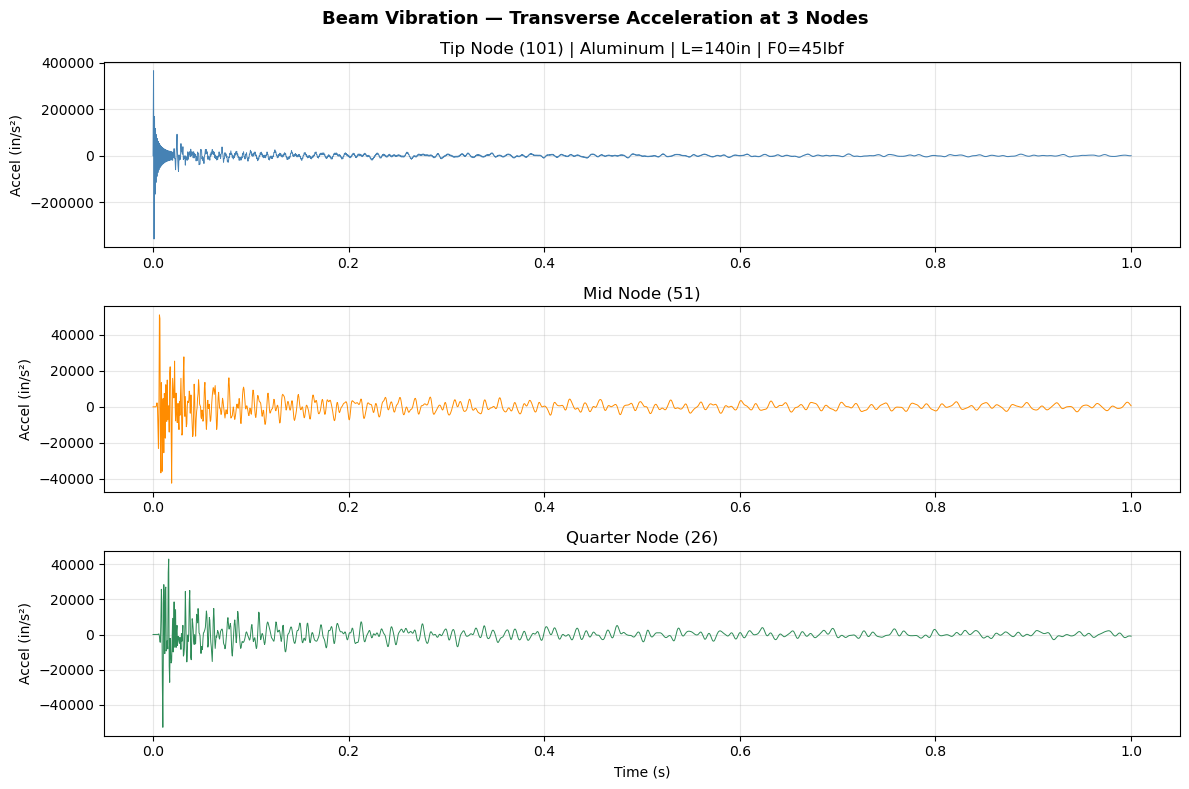

Plot saved to sample_simulation.png

All done. Files saved:
  beam_vibration_dataset.csv
  time_vector.csv
  sample_simulation.png


In [ ]:


import time
import numpy as np
from sampling import generate_parameter_sets
from batch_runner import run_batch
from exporter import export_results_to_csv, export_time_vector

# -------------------------------------------------------------
# STEP 1 — Generate parameter sets
# -------------------------------------------------------------
print("=" * 55)
print("STEP 1 — Generating 500 parameter sets")
print("=" * 55)

param_sets = generate_parameter_sets(mode=1)

print(f"  Parameter sets ready : {len(param_sets)}")
print()

# -------------------------------------------------------------
# STEP 2 — Run full batch in parallel
# -------------------------------------------------------------
print("=" * 55)
print("STEP 2 — Running 500 simulations in parallel")
print("=" * 55)

start_time = time.time()

results, n_success, n_failed = run_batch(param_sets, n_jobs=-1)

elapsed = time.time() - start_time

print()
print(f"  Total time     : {round(elapsed, 2)} s")
print(f"  Time per sim   : {round(elapsed / len(param_sets), 3)} s")
print()

# -------------------------------------------------------------
# STEP 3 — Export results to CSV
# -------------------------------------------------------------
print("=" * 55)
print("STEP 3 — Exporting results to CSV")
print("=" * 55)

df = export_results_to_csv(
    results,
    output_path='beam_vibration_dataset.csv',
    encoding='A'
)

export_time_vector(output_path='time_vector.csv')

# -------------------------------------------------------------
# STEP 4 — Summary statistics
# -------------------------------------------------------------
print()
print("=" * 55)
print("STEP 4 — Summary")
print("=" * 55)
print(f"  Simulations total    : {len(param_sets)}")
print(f"  Succeeded            : {n_success}")
print(f"  Failed               : {n_failed}")
print(f"  CSV shape            : {df.shape}")
print(f"  Total time           : {round(elapsed, 2)} s")
print()
print("Materials in dataset:")
print(df['material'].value_counts().to_string())
print()
print("Length distribution:")
print(df['length_in'].value_counts().sort_index().to_string())
print()
print("Example row (first sim metadata):")
meta_cols = ['sim_id', 'material', 'E_psi', 'length_in',
             'width_in', 'thickness_in', 'impact_F0_lbf',
             'impact_tau_s', 'rayleigh_alpha', 'rayleigh_beta',
             'dt_s', 'T_s', 'n_steps', 'n_elements', 'n_nodes']
print(df[meta_cols].iloc[0].to_string())
print()

# -------------------------------------------------------------
# STEP 5 — Quick plot for one simulation
# -------------------------------------------------------------
print("=" * 55)
print("STEP 5 — Plotting sample simulation")
print("=" * 55)

import matplotlib.pyplot as plt
from config import DT, N_STEPS

# Pick first successful result
r           = next(r for r in results if r['status'] == 'success')
node_accels = r['node_accels']
time_vector = np.linspace(0, DT * (N_STEPS - 1), N_STEPS)

fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Tip node
axes[0].plot(time_vector, node_accels[100, :],
             color='steelblue', linewidth=0.7)
axes[0].set_title(
    f"Tip Node (101) | {r['params']['material'].title()} | "
    f"L={r['params']['length_in']}in | "
    f"F0={r['params']['impact_F0_lbf']}lbf")
axes[0].set_ylabel("Accel (in/s²)")
axes[0].grid(True, alpha=0.3)

# Mid node
axes[1].plot(time_vector, node_accels[50, :],
             color='darkorange', linewidth=0.7)
axes[1].set_title("Mid Node (51)")
axes[1].set_ylabel("Accel (in/s²)")
axes[1].grid(True, alpha=0.3)

# Quarter node
axes[2].plot(time_vector, node_accels[25, :],
             color='seagreen', linewidth=0.7)
axes[2].set_title("Quarter Node (26)")
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Accel (in/s²)")
axes[2].grid(True, alpha=0.3)

plt.suptitle("Beam Vibration — Transverse Acceleration at 3 Nodes",
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_simulation.png', dpi=150)
plt.show()

print("Plot saved to sample_simulation.png")
print()
print("All done. Files saved:")
print("  beam_vibration_dataset.csv")
print("  time_vector.csv")
print("  sample_simulation.png")

 STEP 1 — Generating parameter sets
Total possible combinations : 720
Simulations requested       : 500
  Parameter sets ready  : 500

  Sample of first 3 simulations:
    sim 000 | aluminum   | L=  140 in | b=0.5 in | F0=   45 lbf
    sim 001 | aluminum   | L=  140 in | b=0.5 in | F0=   90 lbf
    sim 002 | aluminum   | L=   40 in | b=0.3 in | F0=   60 lbf

 STEP 2 — Running simulations in parallel
  Total simulations : 500
  CPU cores         : -1 (-1 = all available)

Starting batch of 500 simulations...
Using n_jobs = -1 (−1 means all CPU cores)



Simulations: 100%|██████████| 500/500 [00:28<00:00, 17.72sim/s]



Batch complete.
  Succeeded : 500
  Failed    : 0

  Total time        : 30.18 s  (0.5 min)
  Time per sim      : 0.06 s
  Succeeded         : 500
  Failed            : 0

 STEP 3 — Exporting one CSV per simulation
Exporting simulations to folder: 'simulation_results'
Encoding : A

Files exported : 500
Files skipped  : 0 (failed simulations)
Output folder  : c:\Users\G_Modak\Desktop\PhD work\Trial 26 Feb 2026\simulation_results
Size per file  : ~2.43 MB
Total est size : ~1215.0 MB

Time vector saved : simulation_results\time_vector.csv
  Steps   : 2000
  t_start : 0.0 s
  t_end   : 1.0 s
  dt      : 0.0005 s


 STEP 4 — Summary statistics
  Total simulations  : 500
  Succeeded          : 500
  Failed             : 0
  Files exported     : 500
  Output folder      : c:\Users\G_Modak\Desktop\PhD work\Trial 26 Feb 2026\simulation_results

  Material distribution:
    steel        : 257 simulations
    aluminum     : 243 simulations

  Length distribution:
    L =    20 in  : 61 simulatio

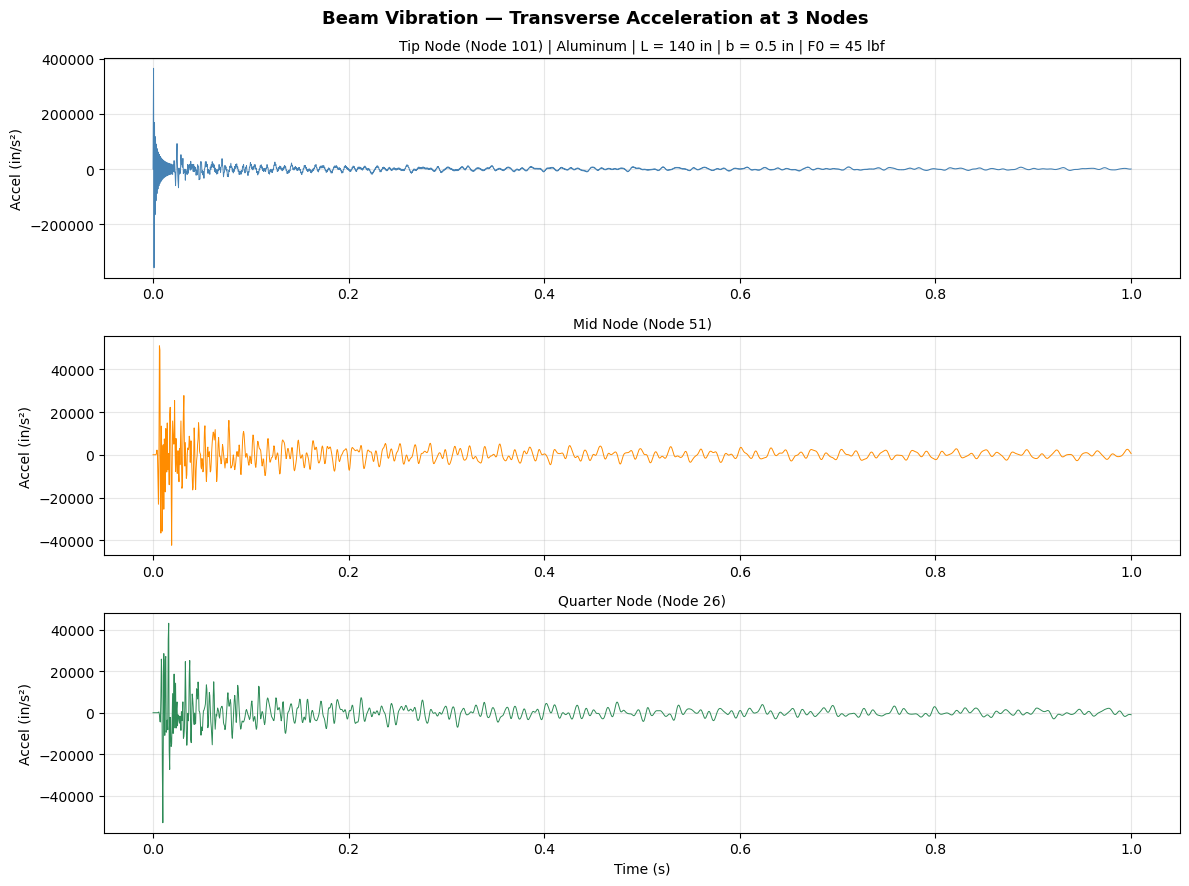

  Plot saved to: simulation_results\sample_simulation.png

 STEP 6 — Output files
  Location : c:\Users\G_Modak\Desktop\PhD work\Trial 26 Feb 2026\simulation_results

  Files created:
    sim_0000.csv to sim_0499.csv
    time_vector.csv
    sample_simulation.png

  Each CSV contains:
    - 1 row
    - 17 metadata columns (beam parameters)
    - 101 node columns (node_001_accel to node_101_accel)
    - Each node column = 2000 acceleration values
      serialized as ';' delimited string

 PIPELINE COMPLETE


In [ ]:
# main.py
# =============================================================
# Main runner — executes full 500 simulation batch
# Euler-Bernoulli Beam FEA — Transient Impact Analysis
# IPS Unit System: inches, lbf, seconds
# =============================================================

import time
import numpy as np
import matplotlib.pyplot as plt
import os

from sampling      import generate_parameter_sets
from batch_runner  import run_batch
from exporter      import export_all_simulations, export_time_vector
from config        import DT, N_STEPS

# =============================================================
# CONFIGURATION
# =============================================================
OUTPUT_DIR    = 'simulation_results'   # folder for all CSV files
N_JOBS        = -1                     # -1 = use all CPU cores
SAMPLING_MODE = 1                      # 1 = discrete, 2 = continuous
ENCODING      = 'A'                    # A = serialized string per node

# =============================================================
# STEP 1 — GENERATE PARAMETER SETS
# =============================================================
print("=" * 60)
print(" STEP 1 — Generating parameter sets")
print("=" * 60)

param_sets = generate_parameter_sets(mode=SAMPLING_MODE)

print(f"  Parameter sets ready  : {len(param_sets)}")
print()
print("  Sample of first 3 simulations:")
for p in param_sets[:3]:
    print(f"    sim {p['sim_id']:03d} | "
          f"{p['material']:<10} | "
          f"L={p['length_in']:5.0f} in | "
          f"b={p['width_in']:.1f} in | "
          f"F0={p['impact_F0_lbf']:5.0f} lbf")
print()

# =============================================================
# STEP 2 — RUN FULL BATCH IN PARALLEL
# =============================================================
print("=" * 60)
print(" STEP 2 — Running simulations in parallel")
print("=" * 60)
print(f"  Total simulations : {len(param_sets)}")
print(f"  CPU cores         : {N_JOBS} (-1 = all available)")
print()

start_time = time.time()

results, n_success, n_failed = run_batch(param_sets, n_jobs=N_JOBS)

elapsed      = time.time() - start_time
time_per_sim = elapsed / len(param_sets)

print()
print(f"  Total time        : {round(elapsed, 2)} s  "
      f"({round(elapsed/60, 2)} min)")
print(f"  Time per sim      : {round(time_per_sim, 3)} s")
print(f"  Succeeded         : {n_success}")
print(f"  Failed            : {n_failed}")
print()

# =============================================================
# STEP 3 — EXPORT ONE CSV PER SIMULATION
# =============================================================
print("=" * 60)
print(" STEP 3 — Exporting one CSV per simulation")
print("=" * 60)

file_paths, n_exported, n_skipped = export_all_simulations(
    results,
    output_dir = OUTPUT_DIR,
    encoding   = ENCODING
)

print()
export_time_vector(output_dir=OUTPUT_DIR)
print()

# =============================================================
# STEP 4 — SUMMARY STATISTICS
# =============================================================
print()
print("=" * 60)
print(" STEP 4 — Summary statistics")
print("=" * 60)

# Collect stats from successful results
materials = [r['params']['material']   for r in results if r['status'] == 'success']
lengths   = [r['params']['length_in']  for r in results if r['status'] == 'success']
widths    = [r['params']['width_in']   for r in results if r['status'] == 'success']
forces    = [r['params']['impact_F0_lbf'] for r in results if r['status'] == 'success']

print(f"  Total simulations  : {len(param_sets)}")
print(f"  Succeeded          : {n_success}")
print(f"  Failed             : {n_failed}")
print(f"  Files exported     : {n_exported}")
print(f"  Output folder      : {os.path.abspath(OUTPUT_DIR)}")
print()

print("  Material distribution:")
for mat in ['steel', 'aluminum']:
    count = materials.count(mat)
    print(f"    {mat:<12} : {count} simulations")
print()

print("  Length distribution:")
for L in sorted(set(lengths)):
    count = lengths.count(L)
    print(f"    L = {L:5.0f} in  : {count} simulations")
print()

print("  Width distribution:")
for b in sorted(set(widths)):
    count = widths.count(b)
    print(f"    b = {b:.1f} in    : {count} simulations")
print()

print("  Force distribution:")
for F in sorted(set(forces)):
    count = forces.count(F)
    print(f"    F0 = {F:5.0f} lbf : {count} simulations")
print()

# Example parameter row
r0 = next(r for r in results if r['status'] == 'success')
print("  Example simulation (first success):")
for k, v in r0['params'].items():
    print(f"    {k:<20} : {v}")
print()

# =============================================================
# STEP 5 — PLOT SAMPLE SIMULATION
# =============================================================
print("=" * 60)
print(" STEP 5 — Plotting sample simulation")
print("=" * 60)

node_accels = r0['node_accels']
time_vector = np.linspace(0, DT * (N_STEPS - 1), N_STEPS)

fig, axes = plt.subplots(3, 1, figsize=(12, 9))

# Tip node — node 100
axes[0].plot(time_vector, node_accels[100, :],
             color='steelblue', linewidth=0.7)
axes[0].set_title(
    f"Tip Node (Node 101) | "
    f"{r0['params']['material'].title()} | "
    f"L = {r0['params']['length_in']} in | "
    f"b = {r0['params']['width_in']} in | "
    f"F0 = {r0['params']['impact_F0_lbf']} lbf",
    fontsize=10)
axes[0].set_ylabel("Accel (in/s²)")
axes[0].grid(True, alpha=0.3)

# Mid node — node 50
axes[1].plot(time_vector, node_accels[50, :],
             color='darkorange', linewidth=0.7)
axes[1].set_title("Mid Node (Node 51)", fontsize=10)
axes[1].set_ylabel("Accel (in/s²)")
axes[1].grid(True, alpha=0.3)

# Quarter node — node 25
axes[2].plot(time_vector, node_accels[25, :],
             color='seagreen', linewidth=0.7)
axes[2].set_title("Quarter Node (Node 26)", fontsize=10)
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Accel (in/s²)")
axes[2].grid(True, alpha=0.3)

plt.suptitle(
    "Beam Vibration — Transverse Acceleration at 3 Nodes",
    fontsize=13, fontweight='bold')
plt.tight_layout()

plot_path = os.path.join(OUTPUT_DIR, 'sample_simulation.png')
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"  Plot saved to: {plot_path}")

# =============================================================
# STEP 6 — FINAL FILE SUMMARY
# =============================================================
print()
print("=" * 60)
print(" STEP 6 — Output files")
print("=" * 60)
print(f"  Location : {os.path.abspath(OUTPUT_DIR)}")
print()
print("  Files created:")
print(f"    sim_0000.csv to sim_{n_exported-1:04d}.csv")
print(f"    time_vector.csv")
print(f"    sample_simulation.png")
print()
print("  Each CSV contains:")
print("    - 1 row")
print("    - 17 metadata columns (beam parameters)")
print("    - 101 node columns (node_001_accel to node_101_accel)")
print("    - Each node column = 2000 acceleration values")
print("      serialized as ';' delimited string")
print()
print("=" * 60)
print(" PIPELINE COMPLETE")
print("=" * 60)

 BEAM VIBRATION VISUALIZATION
Loaded  : sim_0250.csv
  Material   : steel
  Length     : 100.0 in
  Width      : 0.1 in
  Force      : 45.0 lbf
  n_nodes    : 101
  n_steps    : 2000
  dt         : 0.0005002501250625 s
  f_nyquist  : 999.5 Hz

  Frequency range : 1 Hz to 999.5 Hz
  X-axis scale    : log
  Y-axis scale    : linear

[1/5] Plotting time history...
Time history plot saved: simulation_results/plots\sim_0250_time_history.png


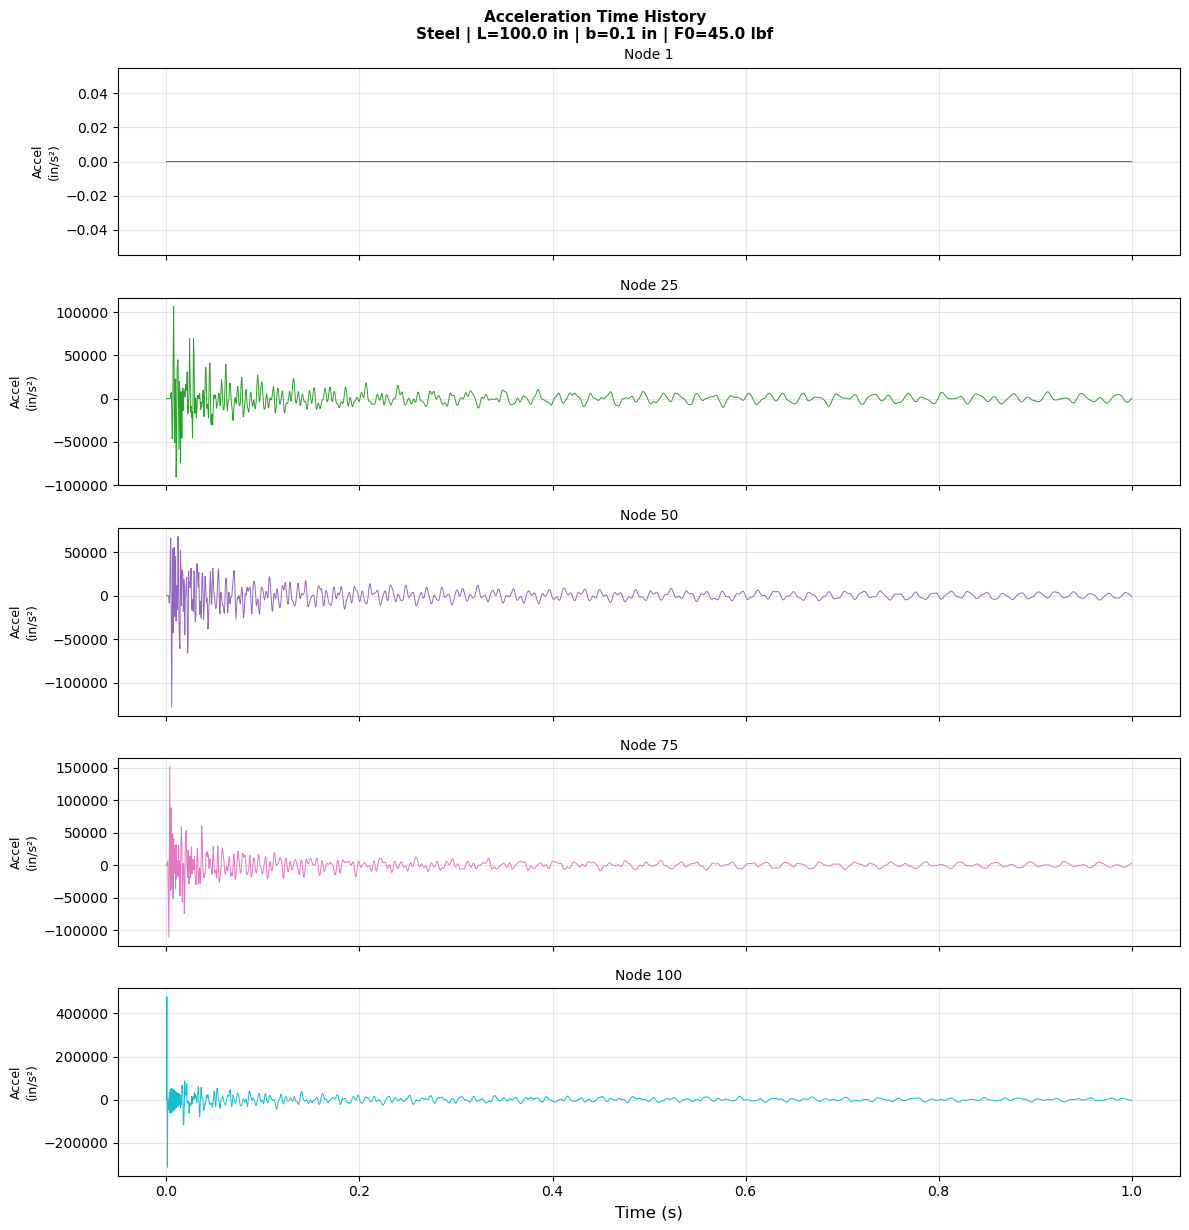


[2/5] Computing and plotting FFT...
FFT plot saved: simulation_results/plots\sim_0250_fft.png


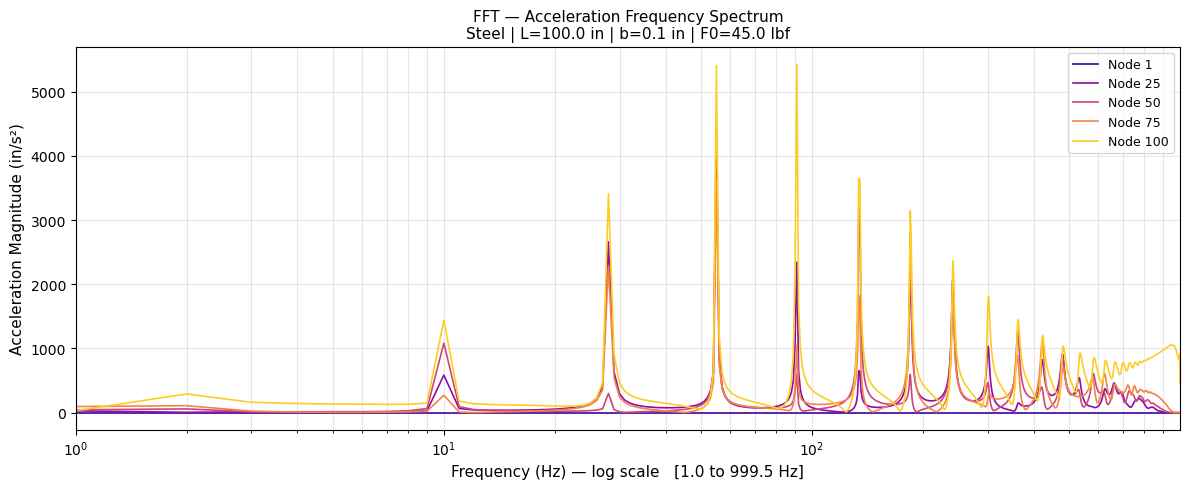


[3/5] Plotting FFT waterfall...
Waterfall plot saved: simulation_results/plots\sim_0250_fft_waterfall.png


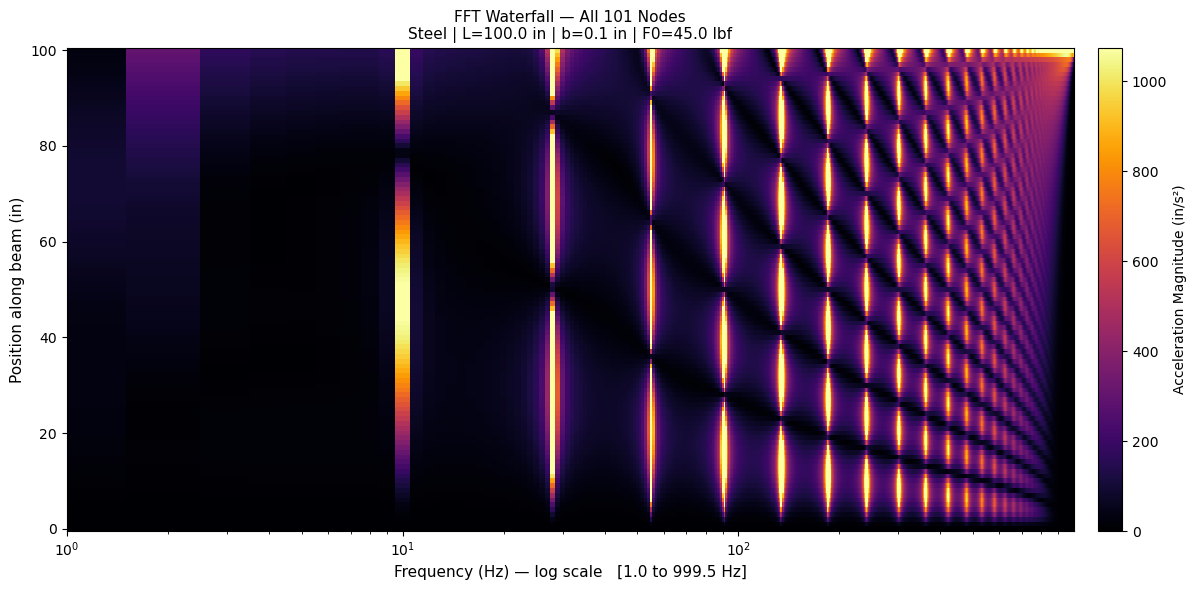


[4/5] Computing and plotting FRF...
FRF plot saved: simulation_results/plots\sim_0250_frf.png


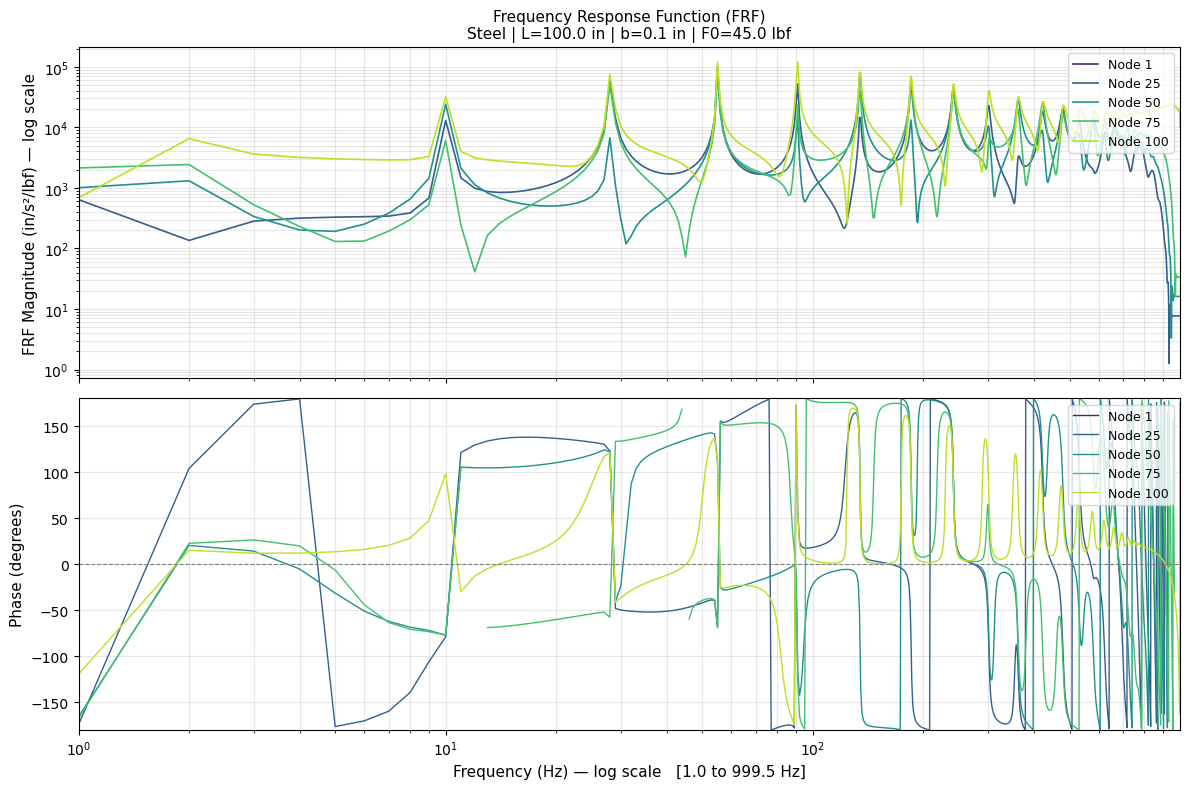


[5/5] Computing exact mode shapes via eigenvalue analysis...

Eigenvalue-based natural frequencies:
  Mode 1: 1.61 Hz
  Mode 2: 10.07 Hz
  Mode 3: 28.19 Hz
  Mode 4: 55.24 Hz
  Mode 5: 91.32 Hz
  Mode 6: 136.42 Hz
Mode shape plot saved: simulation_results/plots\sim_0250_mode_shapes.png


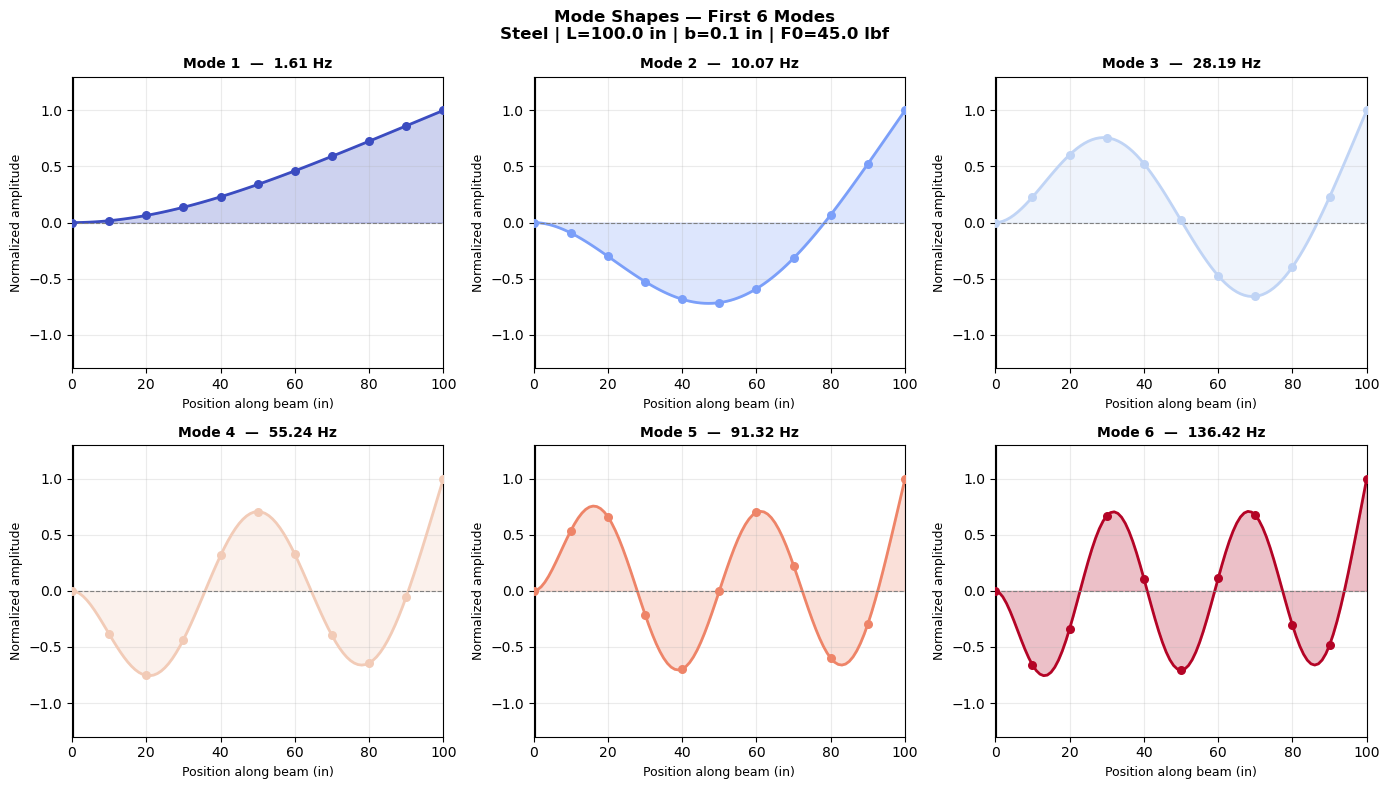


 VISUALIZATION COMPLETE
 Plots saved to: c:\Users\G_Modak\Desktop\PhD work\Trial 26 Feb 2026\simulation_results\plots


In [9]:
from importlib import reload
import visualization
reload(visualization)
from visualization import run_visualization

run_visualization(
    csv_file_path = 'simulation_results/sim_0250.csv',
    output_dir    = 'simulation_results/plots',
    n_modes       = 6,
    nodes_to_plot = [0, 24, 49, 74, 99]
)